current Q = $ state \times weight $

target Q = $ reward + \gamma \, max_{a'} Q(s', a') $

goal: minimize $(target - current)^2$

solution → gradient: $2\, (target - state \times weight)\, state $

In [ ]:
import torch

In [ ]:
a = torch.zeros(5, 3, require_grad=False)

In [ ]:
print(a)
print(a.dtype)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
torch.float32


In [ ]:
!pip3 install torch torchvision

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
state = torch.tensor([[-1.0],  [0.0], [1.0], [2.0], [3.0], [4.0]], dtype=torch.float)
Q_target = torch.tensor([[-3.0], [-1.5], [2.0], [3.0], [4.0], [7.0]], dtype=torch.float)

print(f'state shape: {state.shape}')
print(f'Q target shape: {Q_target.shape}')

layer1 = nn.Linear(1,1, bias=True)
relu = nn.ReLU()
layer2 = nn.Linear(1,1, bias=True)
model = nn.Sequential(layer1,
                      relu,
                      layer2)

Q_current = model(state)
print(f'Q current shape: {Q_current.shape}')

state shape: torch.Size([6, 1])
Q target shape: torch.Size([6, 1])
Q current shape: torch.Size([6, 1])


layer2 * relu(layer1) * state
(layer3) * state

ax + b

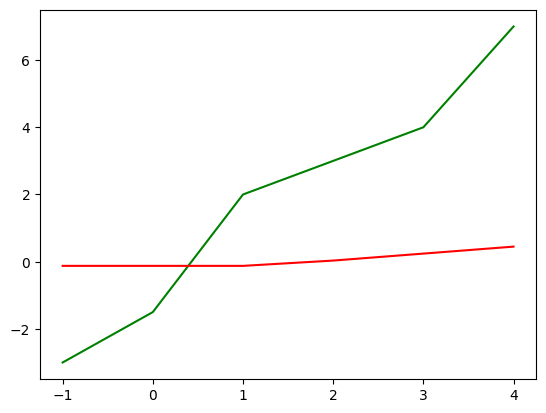

In [ ]:
plt.plot(state.detach().numpy(), Q_target.detach().numpy(), color='green')
plt.plot(state.detach().numpy(), Q_current.detach().numpy(), color='red')
plt.show()

In [ ]:
loss_fc = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
for ITER in range(500):
    model = model.train()

    Q_current = model(state)
    loss = loss_fc(Q_current, Q_target)
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    model.eval()
    if ITER % 50 == 0:
        print('Epoch: %d | Loss: %.4f' %(ITER, loss.detach().item()))

Epoch: 0 | Loss: 13.4231
Epoch: 50 | Loss: 1.5629
Epoch: 100 | Loss: 1.1223
Epoch: 150 | Loss: 0.9301
Epoch: 200 | Loss: 0.8131
Epoch: 250 | Loss: 0.7251
Epoch: 300 | Loss: 0.6543
Epoch: 350 | Loss: 0.5965
Epoch: 400 | Loss: 0.5490
Epoch: 450 | Loss: 0.5102


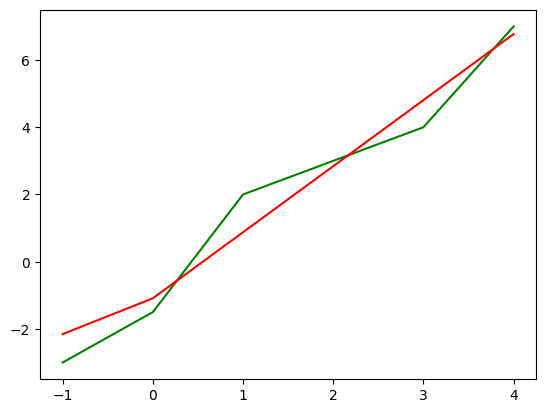

In [ ]:
plt.plot(state.detach().numpy(), Q_target.detach().numpy(), color='green')
plt.plot(state.detach().numpy(), Q_current.detach().numpy(), color='red')
plt.show()

In [ ]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
class QEstimator(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(QEstimator, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, output_dim),
        )
        self.seq.apply(init_weights)

    def forward(self, state):
        state = torch.tensor(state)
        q_value = self.seq(state)
        return q_value

In [ ]:
import random
from collections import deque

class QLearner:
    def __init__(self, state_space_size, action_space_size, learning_rate=0.01, discount_factor=0.95):
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.discount_factor = discount_factor

        self.model = QEstimator(state_space_size, action_space_size)

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

        self.pointer = 0
        self.buffer = deque(maxlen=2000)

    def select_action(self, state):
        q_values = self.model(state).detach().numpy()
        return np.argmax(q_values)

    def replay(self, batch_size):
        if len(self.buffer) < batch_size:
            return

        minibatch = random.sample(self.buffer, batch_size)
        states, targets = [], []

        for state, action, reward, next_state, done in minibatch:
            target = reward

            next_state = torch.tensor(next_state)
            if done:
                target = reward
            else:
                target = reward + self.discount_factor * torch.max(self.model(next_state)).item()

            state = torch.tensor(state)
            target_q_values = self.model(state).detach().numpy()
            target_q_values[action] = target
            states.append(state)
            targets.append(target_q_values)

        states = torch.tensor(np.vstack(states))
        targets = torch.tensor(np.vstack(targets))
        self.optimizer.zero_grad()
        loss = self.criterion(self.model(states), targets)
        loss.backward()
        self.optimizer.step()

    def add_episode(self, state, action, reward, next_state, done):
        self.buffer.append([state, action, reward, next_state, done])


In [ ]:
import gym
from gym import wrappers
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("CartPole-v1")

train_step = 500
batch_size = 32
epsilon = 0.2

agent = QLearner(env.observation_space._shape[0], env.action_space.n, learning_rate=0.001)
mean_rewards = np.array([])
for i in range(train_step):
    total_reward = 0
    state = env.reset()
    while True:
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = agent.select_action(state)

        next_state, reward, done, _ = env.step(action)

        agent.add_episode(state, action, reward, next_state, done)

        total_reward += reward

        state = next_state

        if done:
            break

    agent.replay(batch_size)

    agent.update_target()

env.close()

In [ ]:
!pip install "gym[accept-rom-license, atari]"
!pip install "gymnasium[atari, accept-rom-license]"
!pip install pip install ale-py

In [ ]:
!pip install "ray[rllib]" tensorflow torch

In [ ]:
from ray.rllib.algorithms.ppo import PPOConfig, PPOTrainer
from ray.tune.logger import pretty_print

config = (
    PPOConfig()
    .environment("Taxi-v3")
    .rollouts(num_rollout_workers=1)
    .framework("torch")
    .training(model={"fcnet_hiddens": [64, 64]})
    .evaluation(evaluation_num_workers=1)
)

algo = config.build()

for i in range(5):
    result = algo.train()
    print(pretty_print(result))
    print("done!")

algo.evaluate()

In [ ]:

tune.run(PPOTrainer, stop={"episode_reward_mean": 200},
         config={
             "env": "ALE/Breakout-v5",
             "num_gpus": 0,
             "monitor": True,
             "evaluation_num_episodes": 25,
             "num_workers": 0,
             "double_q": True,
             "dueling": True,
             "num_atoms": 1,
             "noisy": False,
             "prioritized_replay": False,
             "n_step": 1,
             "target_network_update_freq": 8000,
             "lr": 0.0000625,
             "adam_epsilon": 0.00015,
             "hiddens": [512],
             "learning_starts": 20000,
             "buffer_size": 400_000,
             "rollout_fragment_length": 4,
             "train_batch_size": 32,
             "exploration_config": {
                 "epsilon_timesteps": 500_000,
                 "final_epsilon": 0.01,
             },
             "prioritized_replay_alpha": 0.5,
             "final_prioritized_replay_beta": 1.0,
             "prioritized_replay_beta_annealing_timesteps": 2_000_000,
             "timesteps_per_iteration": 10_000,
         })

In [ ]:
!pip install pybullet
!pip install gym[atari] autorom[accept-rom-license]

In [ ]:
import gymnasium as gym
env = gym.make("Taxi-v3")
ray.rllib.utils.check_env(env)

In [ ]:
import ray
from ray import tune
from ray.rllib.algorithms.ppo import PPO

ray.shutdown()
ray.init()

ppo_config = {
    "env": "Taxi-v3",
    "num_workers": 4,
    "num_gpus": 1,
    "lr": 0.0001,
    "gamma": 0.99,
    "train_batch_size": 5000
}

trainer = PPO(config=ppo_config)


for i in range(5):
    result = trainer.train()
    print(f"Iteration {i + 1}: {result}")

checkpoint_path = trainer.save("./ppo_breakout")
trainer.restore(checkpoint_path)
ray.shutdown()

In [ ]:
import argparse
import gymnasium as gym
import os

import ray
from ray import air, tune
from ray.rllib.algorithms.algorithm import Algorithm
from ray.tune.registry import get_trainable_cls

ray.shutdown()
ray.init()

config = (
    get_trainable_cls("PPO")
    .get_default_config()
    .environment("FrozenLake-v1")
    .framework("torch")
)

stop = {
    "training_iteration": 200,
    "timesteps_total": 100000,
    "episode_reward_mean": 150,
}

# Training policy until desired reward/timesteps/iterations

tuner = tune.Tuner(
    "PPO",
    param_space=config.to_dict(),
    run_config=air.RunConfig(
        stop=stop,
        verbose=2,
        checkpoint_config=air.CheckpointConfig(
            checkpoint_frequency=1, checkpoint_at_end=True
        ),
    ),
)

results = tuner.fit()

# Training completed. Restoring new Algorithm for action inference

checkpoint = results.get_best_result().checkpoint

algo = Algorithm.from_checkpoint(checkpoint)

env = gym.make("FrozenLake-v1")
obs, info = env.reset()
num_episodes = 0
episode_reward = 0.0

while num_episodes < 10:
    a = algo.compute_single_action(
        observation=obs,
        explore=True,
        policy_id="default_policy",
    )
    obs, reward, done, truncated, _ = env.step(a)
    episode_reward += reward
    if done:
        print(f"Episode done: Total reward = {episode_reward}")
        obs, info = env.reset()
        num_episodes += 1
        episode_reward = 0.0

algo.stop()

ray.shutdown()

In [ ]:
!git clone https://github.com/tomatoeater/Atari-DQN.git

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
%%shell
conda create -n rl python=3.9 -y

In [ ]:
%%shell
source activate rl

conda install pytorch torchvision pytorch-cuda=11.8 -c pytorch -c nvidia

pip install 'gymnasium[atari]'
pip install gymnasium[accept-rom-license]
pip install opencv-python
pip install imageio[ffmpeg]
pip install matplotlib
pip install ipykernel

In [ ]:
%%shell
source activate rl
cd Atari-DQN

python main.py --env-name breakout --model dqn --epoch 200 --eval-cycle 100

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/Atari-DQN/log_breakout/dqn/100.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)